# Tracks Tavern Linear Regression Machine Learning Model

The purpose of this Machine Learning model is to explore if we can use the sales data since february 2019 and the weather information to predict sales information. We will analyze the sales of different categories, compare with weather for the period and look for any corralations that can help us in our prediction.


In [1]:
# Import dependecies

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
# SQL Connection to Sales

import sqlalchemy as sql
engine = sql.create_engine("sqlite:///../Database/sales.db")
df = pd.read_sql("sales", con=engine)
df

,index,item,item_code,quantity,unit_price,total_sales_amount,date,Type
0,0,PINT Spotted Cow,3140,64,3.937500,252.00,2021-01-08,Beer
1,1,DBL RAIL Vodka,3455,37,4.945946,183.00,2021-01-08,Vodka
2,2,BTL Miller High Life,3122,31,3.250000,100.75,2021-01-08,Beer
3,3,PINT Stein,3141,29,3.517241,102.00,2021-01-08,Beer
4,4,SHOT Seagrams VO,3325,26,2.423077,63.00,2021-01-08,Scotch/Whiskey
...,...,...,...,...,...,...,...,...
23841,23841,Skyy Watermelon BOMB,3374,1,4.000000,4.00,2020-01-03,Vodka
23842,23842,PIT LKFT Hazy Rabbit,3359,1,15.000000,15.00,2020-01-03,Beer
23843,23843,PIT Abita TurboDog,3363,1,15.000000,15.00,2020-01-03,Beer
23844,23844,SHOT Titos,3655,1,0.000000,0.00,2020-01-03,Vodka


In [3]:
df.Type = df.Type.str.lower()
df.columns = df.columns.str.lower()
df.head()

,index,item,item_code,quantity,unit_price,total_sales_amount,date,type
0,0,PINT Spotted Cow,3140,64,3.937500,252.00,2021-01-08,beer
1,1,DBL RAIL Vodka,3455,37,4.945946,183.00,2021-01-08,vodka
2,2,BTL Miller High Life,3122,31,3.250000,100.75,2021-01-08,beer
3,3,PINT Stein,3141,29,3.517241,102.00,2021-01-08,beer
4,4,SHOT Seagrams VO,3325,26,2.423077,63.00,2021-01-08,scotch/whiskey


In [4]:
# Convert date into datetime format
df['date'] = pd.to_datetime(df['date'])
df.dtypes

index                          int64
item                          object
item_code                      int64
quantity                       int64
unit_price                   float64
total_sales_amount           float64
date                  datetime64[ns]
type                          object
dtype: object

In [5]:
df = df.drop(columns=['index'])
df.head()

,item,item_code,quantity,unit_price,total_sales_amount,date,type
0,PINT Spotted Cow,3140,64,3.937500,252.00,2021-01-08,beer
1,DBL RAIL Vodka,3455,37,4.945946,183.00,2021-01-08,vodka
2,BTL Miller High Life,3122,31,3.250000,100.75,2021-01-08,beer
3,PINT Stein,3141,29,3.517241,102.00,2021-01-08,beer
4,SHOT Seagrams VO,3325,26,2.423077,63.00,2021-01-08,scotch/whiskey


In [6]:
df.type.value_counts().head(10)

beer              3926
vodka             2790
scotch/whiskey    2034
nonalcoholic      1848
side              1812
appetizers        1061
special           1042
fish               997
tequila            865
liqueur            845
Name: type, dtype: int64

## Main Type
Based on the value counts the main categories are the following:

['beer', 'vodka', 'scotch/whiskey', 'nonalcoholic', 'side', 'appetizers', 'fish', 'special']

based this information these are the type we will use as our feature for our machine learning model.

We will create a column for each type grouping by date sumarizing the quantity per date.

In [7]:
# Creating Beer DF to be used as target column on our Model.

beer_df = df[(df.type == "beer" )].drop(columns=['item', 'item_code', 'unit_price','type', 'total_sales_amount'])
beer_df = beer_df.groupby(['date']).sum().rename(columns={'quantity': 'beer_qty'})
beer_df.head()

,beer_qty
date,
2019-02-15,288
2019-02-22,587
2019-03-01,658
2019-03-08,640
2019-03-15,633


In [8]:
# Creating Feature df to be use as columns for the rest of the main types for our model.

#Vodka DF
vodka_df = df[(df.type == "vodka" )].drop(columns=['item', 'item_code', 'unit_price','type', 'total_sales_amount'])
vodka_df = vodka_df.groupby(['date']).sum().rename(columns={'quantity': 'vodka_qty'})

#Scotch Whiskey DF
scotch_df = df[(df.type == 'scotch/whiskey' )].drop(columns=['item', 'item_code', 'unit_price','type', 'total_sales_amount'])
scotch_df= scotch_df.groupby(['date']).sum().rename(columns={'quantity': 'scotch_qty'})

# nonalcoholic DF
nonalcoholic_df = df[(df.type == 'nonalcoholic' )].drop(columns=['item', 'item_code', 'unit_price','type', 'total_sales_amount'])
nonalcoholic_df = nonalcoholic_df.groupby(['date']).sum().rename(columns={'quantity': 'nonalcoholic_qty'})

# side
side_df = df[(df.type == 'side' )].drop(columns=['item', 'item_code', 'unit_price','type', 'total_sales_amount'])
side_df = side_df.groupby(['date']).sum().rename(columns={'quantity': 'side_qty'})

# appetizers
apps_df = df[(df.type == 'appetizers' )].drop(columns=['item', 'item_code', 'unit_price','type', 'total_sales_amount'])
apps_df = apps_df.groupby(['date']).sum().rename(columns={'quantity': 'apps_qty'})

# fish
fish_df = df[(df.type == 'fish' )].drop(columns=['item', 'item_code', 'unit_price','type', 'total_sales_amount'])
fish_df = fish_df.groupby(['date']).sum().rename(columns={'quantity': 'fish_qty'})

# special
special_df = df[(df.type == 'special' )].drop(columns=['item', 'item_code', 'unit_price','type', 'total_sales_amount'])
special_df = special_df.groupby(['date']).sum().rename(columns={'quantity': 'special_qty'})


In [9]:

special_df.head()

,special_qty
date,
2019-02-15,26
2019-02-22,44
2019-03-01,54
2019-03-08,63
2019-03-15,80


In [10]:
# Joining all the individual target and feature df in a single dataframe.

feature_df = ((((((beer_df.join(vodka_df, how='outer')).join(scotch_df, how='outer'))\
.join(nonalcoholic_df, how = 'outer')).join(side_df, how='outer')).join(apps_df, how='outer'))\
    .join(fish_df, how='outer')).join(special_df, how = 'outer')
feature_df

,beer_qty,vodka_qty,scotch_qty,nonalcoholic_qty,side_qty,apps_qty,fish_qty,special_qty
date,,,,,,,,
2019-02-15,288.0,119.0,87.0,41.0,22.0,40.0,55.0,26.0
2019-02-22,587.0,273.0,175.0,90.0,66.0,141.0,81.0,44.0
2019-03-01,658.0,329.0,232.0,70.0,46.0,124.0,86.0,54.0
2019-03-08,640.0,311.0,205.0,94.0,56.0,157.0,140.0,63.0
2019-03-15,633.0,308.0,187.0,101.0,60.0,146.0,131.0,80.0
...,...,...,...,...,...,...,...,...
2021-08-27,564.0,319.0,167.0,58.0,55.0,108.0,48.0,62.0
2021-09-03,596.0,367.0,176.0,78.0,63.0,114.0,65.0,61.0
2021-09-10,613.0,312.0,253.0,58.0,66.0,119.0,82.0,52.0


## Weather
The historical weather data for Track Taverns zip code was gather from openweather.com. since our sales data is weekly data, our weather data set has previouly been, clean and transform into weekly average weather. for our model we will focus in the temperature, minimun temperature and maximun temperature.

In [11]:
# SQL Connection to weather data set, importing only needed columns
cols = ['temp', 'temp_min', 'temp_max']
engine = sql.create_engine("sqlite:///../Database/sales.db")
weather_df = pd.read_sql("weather", con=engine, index_col=['dt'], columns=cols)
weather_df

,temp,temp_min,temp_max
dt,,,
2019-02-15,23.368876,-5.10,41.14
2019-02-22,22.586823,0.37,42.76
2019-03-01,15.662619,-8.72,31.91
2019-03-08,34.007813,5.77,62.64
2019-03-15,36.160057,21.74,52.23
...,...,...,...
2021-08-20,75.183600,55.65,94.64
2021-08-27,73.168103,50.77,93.42
2021-09-03,66.520357,48.65,81.84


In [12]:
# Changing index date format to datetime
weather_df.index = pd.to_datetime(weather_df.index)
weather_df.dtypes

temp        float64
temp_min    float64
temp_max    float64
dtype: object

In [13]:
# Joining the weather dataframe with the feature datafreme.

complete_df = feature_df.join(weather_df, how='outer').reset_index(col_level='date')
complete_df.dropna(inplace=True)
complete_df

,index,beer_qty,vodka_qty,scotch_qty,nonalcoholic_qty,side_qty,apps_qty,fish_qty,special_qty,temp,temp_min,temp_max
0,2019-02-15,288.0,119.0,87.0,41.0,22.0,40.0,55.0,26.0,23.368876,-5.10,41.14
1,2019-02-22,587.0,273.0,175.0,90.0,66.0,141.0,81.0,44.0,22.586823,0.37,42.76
2,2019-03-01,658.0,329.0,232.0,70.0,46.0,124.0,86.0,54.0,15.662619,-8.72,31.91
3,2019-03-08,640.0,311.0,205.0,94.0,56.0,157.0,140.0,63.0,34.007813,5.77,62.64
4,2019-03-15,633.0,308.0,187.0,101.0,60.0,146.0,131.0,80.0,36.160057,21.74,52.23
...,...,...,...,...,...,...,...,...,...,...,...,...
132,2021-08-20,688.0,386.0,287.0,75.0,66.0,150.0,65.0,54.0,75.183600,55.65,94.64
133,2021-08-27,564.0,319.0,167.0,58.0,55.0,108.0,48.0,62.0,73.168103,50.77,93.42
134,2021-09-03,596.0,367.0,176.0,78.0,63.0,114.0,65.0,61.0,66.520357,48.65,81.84
135,2021-09-10,613.0,312.0,253.0,58.0,66.0,119.0,82.0,52.0,67.382024,48.97,87.76


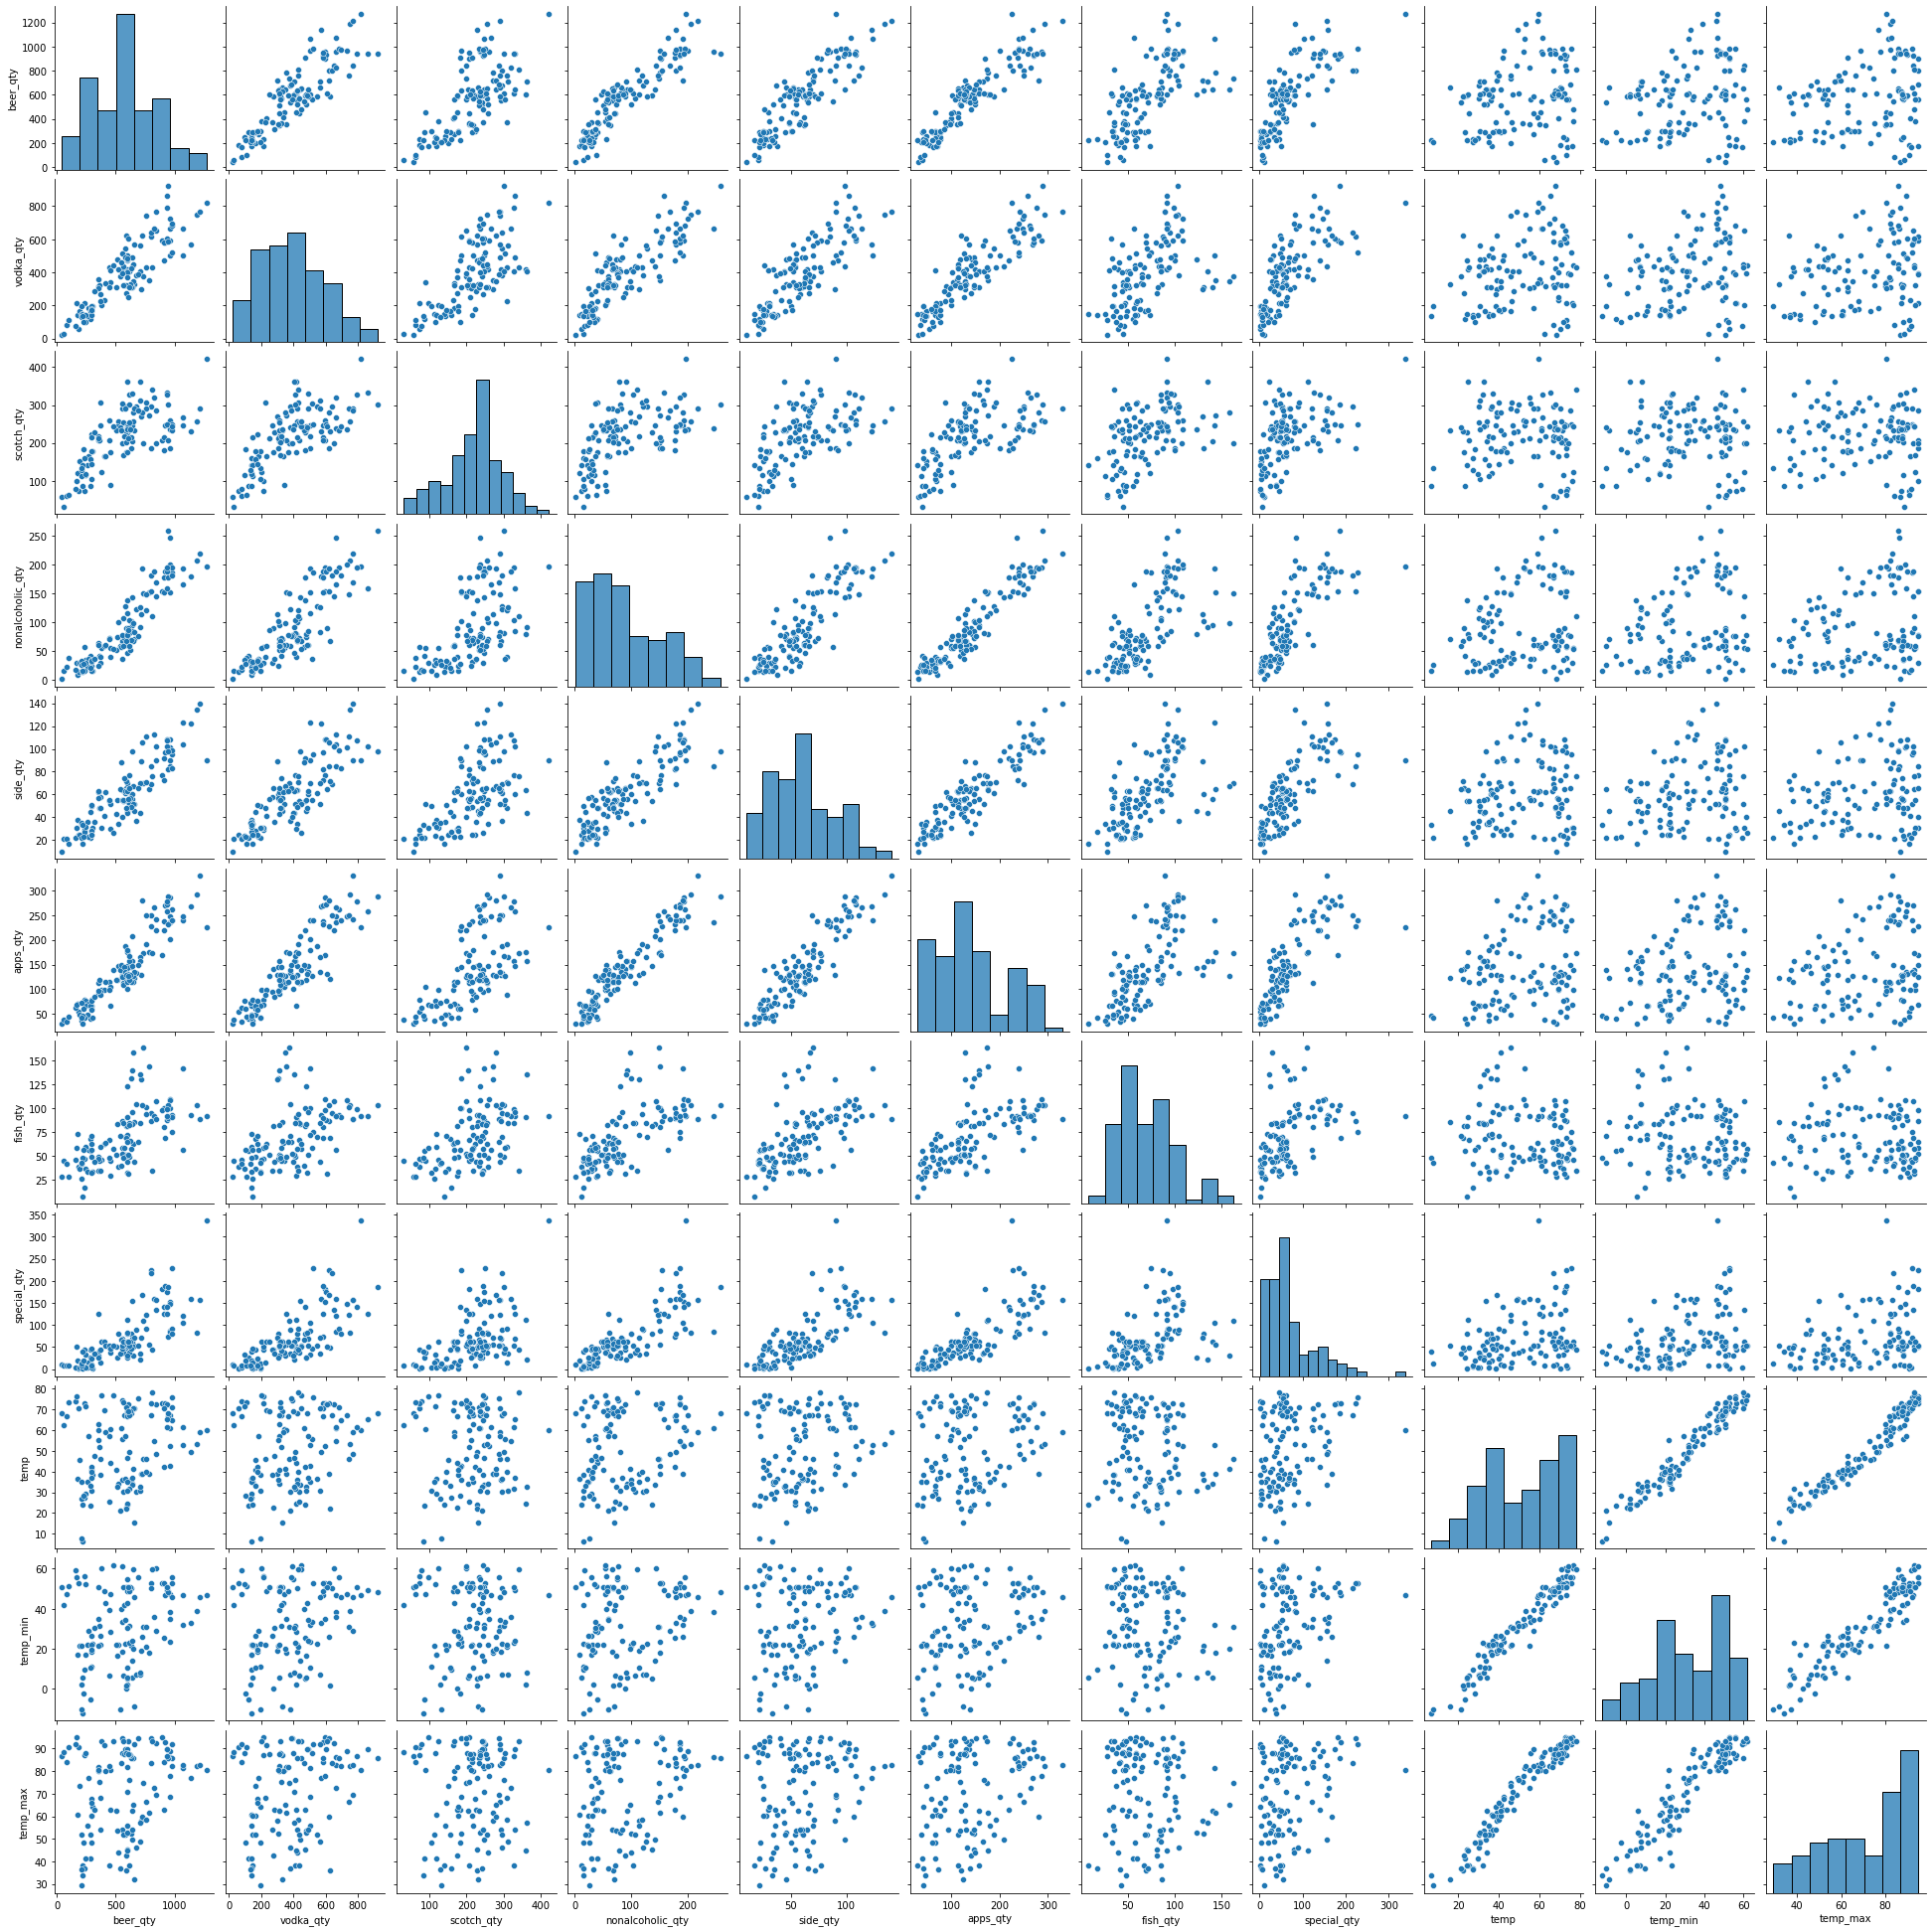

In [14]:
# Plot to verify or spot correlation between variables
sns.pairplot(data=complete_df)

# Variable correlation
From the scatter plots above, we do not see a correlation of any feature with the weather, this might be because our data is affected by covid 19 closures and/or that since our data is for weekly sales, any weather impact on sales can be diluted. Nonetheless, since we spot corralations with the weather, for our model we will drop the temperature columns.

Below with a table with the corralation values corrabolating the fact that there is no corralation between our sales data and the weather.

In [15]:
# Verifying correlation
complete_df.corr()

,beer_qty,vodka_qty,scotch_qty,nonalcoholic_qty,side_qty,apps_qty,fish_qty,special_qty,temp,temp_min,temp_max
beer_qty,1.000000,0.883495,0.684408,0.913189,0.883104,0.926225,0.639749,0.765595,0.233688,0.251327,0.266099
vodka_qty,0.883495,1.000000,0.707688,0.859726,0.829286,0.895799,0.498655,0.744107,0.236854,0.261966,0.257113
scotch_qty,0.684408,0.707688,1.000000,0.559884,0.578404,0.633020,0.463653,0.495766,-0.017108,-0.002603,0.006733
nonalcoholic_qty,0.913189,0.859726,0.559884,1.000000,0.860154,0.946081,0.660766,0.798562,0.221430,0.240844,0.238037
side_qty,0.883104,0.829286,0.578404,0.860154,1.000000,0.915835,0.585914,0.728946,0.186393,0.211353,0.228567
apps_qty,0.926225,0.895799,0.633020,0.946081,0.915835,1.000000,0.620939,0.801017,0.250296,0.269262,0.274785
fish_qty,0.639749,0.498655,0.463653,0.660766,0.585914,0.620939,1.000000,0.468105,-0.127418,-0.126434,-0.060830
special_qty,0.765595,0.744107,0.495766,0.798562,0.728946,0.801017,0.468105,1.000000,0.298471,0.312430,0.302157
temp,0.233688,0.236854,-0.017108,0.221430,0.186393,0.250296,-0.127418,0.298471,1.000000,0.972108,0.969901
temp_min,0.251327,0.261966,-0.002603,0.240844,0.211353,0.269262,-0.126434,0.312430,0.972108,1.000000,0.929961


C:\Users\George\anaconda3\envs\mlenv\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


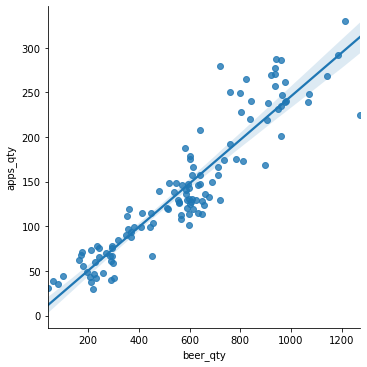

In [16]:
sns.lmplot(x='beer_qty', y='apps_qty', data=complete_df, size=5)

### We will create a month column and use it to see if there is any seasonality that can help our model

In [17]:
complete_df['month'] = complete_df['index'].apply(lambda time: time.month)

In [18]:
complete_df.head()

,index,beer_qty,vodka_qty,scotch_qty,nonalcoholic_qty,side_qty,apps_qty,fish_qty,special_qty,temp,temp_min,temp_max,month
0,2019-02-15,288.0,119.0,87.0,41.0,22.0,40.0,55.0,26.0,23.368876,-5.10,41.14,2
1,2019-02-22,587.0,273.0,175.0,90.0,66.0,141.0,81.0,44.0,22.586823,0.37,42.76,2
2,2019-03-01,658.0,329.0,232.0,70.0,46.0,124.0,86.0,54.0,15.662619,-8.72,31.91,3
3,2019-03-08,640.0,311.0,205.0,94.0,56.0,157.0,140.0,63.0,34.007813,5.77,62.64,3
4,2019-03-15,633.0,308.0,187.0,101.0,60.0,146.0,131.0,80.0,36.160057,21.74,52.23,3


<AxesSubplot:xlabel='month', ylabel='apps_qty'>

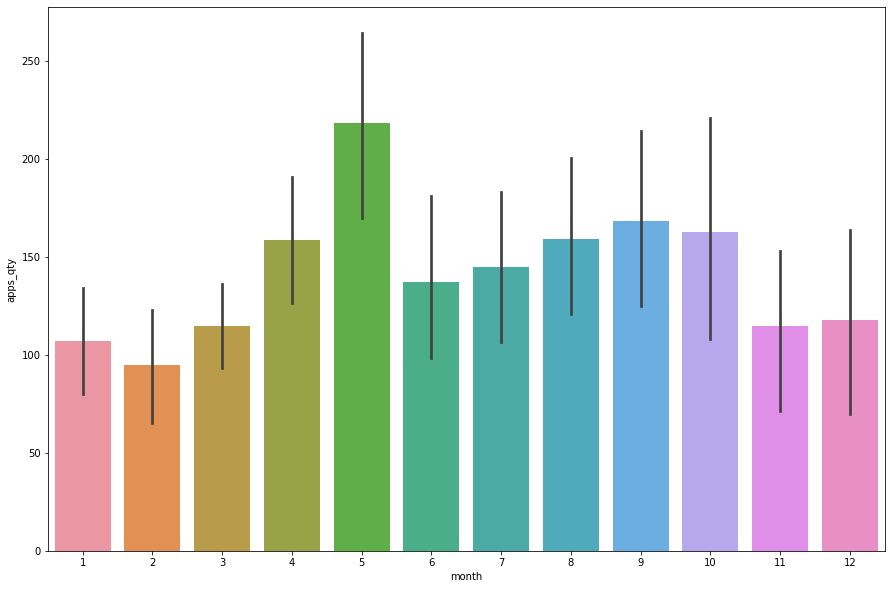

In [19]:
# Visualize beer sales by month
f , ax = plt.subplots(figsize=(15,10))
sns.barplot(x='month', y='apps_qty', data=complete_df)

From the bar graph we spot seasonaly with sales declining in November, December and January.

<AxesSubplot:>

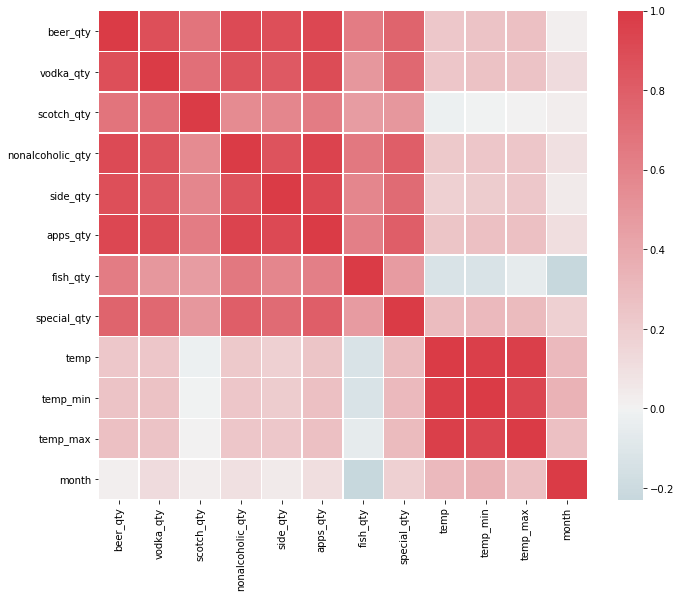

In [20]:
# Correlation heatmap
corr = complete_df.corr()
cmap = sns.diverging_palette(220,10, as_cmap=True)
f, ax = plt.subplots(figsize=(11,9))
sns.heatmap(corr, cmap=cmap, center=0, square=True, linewidths=0.5)

In [21]:
# importing stat functions
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [22]:
# Creating our feature dateframe as X and our dependant df as y ('scotch_qty')


In [23]:
# correlation matrix
matrix_corr = X.corr()
print(matrix_corr)

                  vodka_qty  scotch_qty  nonalcoholic_qty  side_qty  apps_qty  \
vodka_qty          1.000000    0.707688          0.859726  0.829286  0.895799   
scotch_qty         0.707688    1.000000          0.559884  0.578404  0.633020   
nonalcoholic_qty   0.859726    0.559884          1.000000  0.860154  0.946081   
side_qty           0.829286    0.578404          0.860154  1.000000  0.915835   
apps_qty           0.895799    0.633020          0.946081  0.915835  1.000000   
special_qty        0.744107    0.495766          0.798562  0.728946  0.801017   
month              0.119495    0.028163          0.098596  0.047600  0.107588   

                  special_qty     month  
vodka_qty            0.744107  0.119495  
scotch_qty           0.495766  0.028163  
nonalcoholic_qty     0.798562  0.098596  
side_qty             0.728946  0.047600  
apps_qty             0.801017  0.107588  
special_qty          1.000000  0.183901  
month                0.183901  1.000000  


In [24]:
# Calculation our R squared to see how closely the variation of our dependant variable can be explained by the features.
XC = sm.add_constant(X)
model_v1 = sm.OLS(y,XC)
model_v2 = model_v1.fit()
model_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               beer_qty   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     158.6
Date:                Sun, 17 Oct 2021   Prob (F-statistic):           2.23e-55
Time:                        11:46:13   Log-Likelihood:                -708.37
No. Observations:                 121   AIC:                             1433.
Df Residuals:                     113   BIC:                             1455.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               51.1301     31.552      1.621      0.108     -11.380     113.640
vodka_qty            0.1812      0.100      1.818      0.072      -0.016       0.379
scotch_qty           0.5780      0.155      3.727      0.000       0.271       0.885
nonalcoholic_qty     1.7463      0.415      4.204      0.000       0.923       2.569
side_qty             2.0132      0.706      2.852      0.005       0.615       3.412
apps_qty             0.4949      0.474      1.044      0.299      -0.444       1.434
special_qty          0.1781      0.236      0.754      0.452      -0.290       0.646
month               -5.6180      2.529     -2.221      0.028     -10.628      -0.608
==============================================================================
Omnibus:                        1.294   Durbin-Watson:                   0.876
Prob(Omnibus):                  0.524   Jarque-Bera (JB):                1.083
Skew:                          -0.232   Prob(JB):                        0.582
Kurtosis:                       3.020   Cond. No.                     2.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Having confirm that we have a high R^2 value we split, train and test our data using train_test_split for sklearn. We will reserve 30% of the dataset to test the model. To build the model we will use Sklearn Linear Regression model.

In [61]:
# Split the data into train and test 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [62]:
# Create the linear regression model

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.9088639337669631

In [63]:
# Model coefficients
model.coef_

array([ 0.19331991,  0.60362646,  1.37073889,  1.73370093,  0.51365566,
        0.5456311 , -5.06256333])

In [64]:
# Model Y intercept
model.intercept_

60.23830659439625

In [65]:
# Creating a Prediction DF to compare out test y with our predicted y.
prediction_df = X_test

In [66]:
# Calcualted our Predicted y
y_pred = model.predict(X_test)

In [89]:
# Join our Test Y with our preduction DF
prediction_df_v1 = prediction_df.join(y_test, how='outer')
prediction_df_v1['Beer_Predict'] = y_pred

In [90]:
prediction_df_v1

,vodka_qty,scotch_qty,nonalcoholic_qty,side_qty,apps_qty,special_qty,month,beer_qty,Beer_Predict
48,623.0,230.0,68.0,72.0,121.0,49.0,1,588.0,621.373103
110,228.0,308.0,40.0,48.0,88.0,14.0,3,368.0,465.932239
111,174.0,145.0,32.0,51.0,76.0,24.0,3,293.0,350.629486
8,504.0,185.0,151.0,90.0,201.0,86.0,4,962.0,762.275901
113,284.0,227.0,37.0,36.0,85.0,35.0,4,316.0,407.802506
22,619.0,186.0,154.0,85.0,228.0,224.0,7,803.0,854.533134
7,376.0,199.0,149.0,70.0,174.0,110.0,4,737.0,707.792670
10,470.0,182.0,177.0,92.0,219.0,140.0,4,907.0,831.708639
45,500.0,217.0,115.0,70.0,179.0,32.0,12,600.0,615.533039
105,198.0,133.0,26.0,22.0,43.0,12.0,2,208.0,271.088239


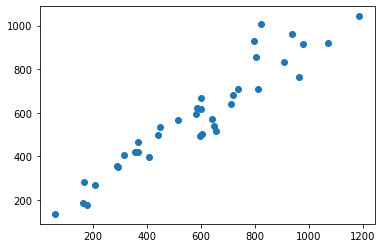

In [79]:
# Y test and Y predicted scatter and see how closely they track
plt.scatter(y_test, y_pred)

(array([ 1.,  2.,  4., 10.,  5.,  3.,  4.,  4.,  3.,  1.]),
 array([-184.38335684, -145.97261125, -107.56186565,  -69.15112006,
         -30.74037447,    7.67037112,   46.08111671,   84.4918623 ,
         122.90260789,  161.31335348,  199.72409908]),
 <BarContainer object of 10 artists>)

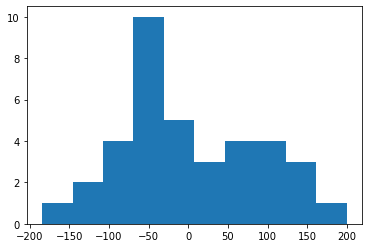

In [80]:
plt.hist(y_test - y_pred)

The predictions for beer quantity below 800, seems to be very closely match, with little discrepancy. when sales go over 800 the model seems to break.

In [94]:
from sklearn import metrics

In [95]:
metrics.mean_absolute_error(y_test, y_pred)

76.49535778793363

In [96]:
metrics.mean_squared_error(y_test, y_pred)

8046.2419821058

In [97]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

89.70084716492816

In [97]:
import pickle

In [98]:
sales_data = open('sales.pkl','wb') 
pickle.dump(complete_df,sales_data)
sales_data.close() 

In [99]:
model_data = open('linear.pkl','wb') 
pickle.dump(prediction_df,model_data)
model_data.close()

In [100]:
df_data = open('df.pkl','wb') 
pickle.dump(df,df_data)
df_data.close()